In [1]:
import rfest

from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
%matplotlib inline

from rfest._utils import get_sdm

## Generate toy dataset

RFEst comes with a simple data generator. Here we generated a stimulus-response pair with a 3D Difference-of-Gaussian filter.

In [2]:
((X, Y), (Xtest, Ytest), 
 w_true) = rfest.make_data(dims=(15, 20, 5), sigma=(1.5, 1.5),
                           n_samples=2000, nsevar=1, 
                           filter_type='mexican_hat', seed=2046)
                          

### ALD

============0============
sigma: 10.0
rho: -2.3
nux: [array(8.), array(10.)]
nuf: [array(1.), array(3.)]
taux: [array(1.5), array(1.8), array(0.)]
tauf: [array(0.15), array(0.15), array(1.)]
cost: 112.15972497991743


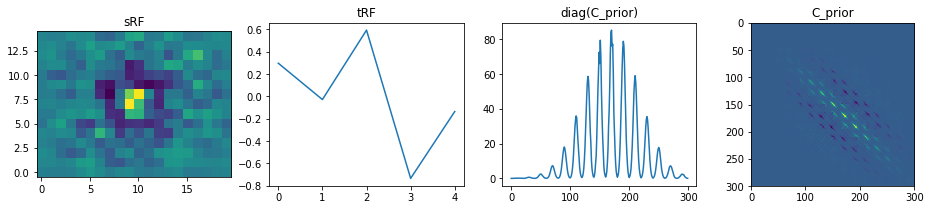

============100============
sigma: 9.899352523850498
rho: -2.20538940500922
nux: [array(8.0950365), array(10.07354571)]
nuf: [array(0.90585134), array(2.90573186)]
taux: [array(1.40160957), array(1.70371971), array(-0.01904698)]
tauf: [array(0.06332468), array(0.06569801), array(1.09142297)]
cost: 106.30557170669657


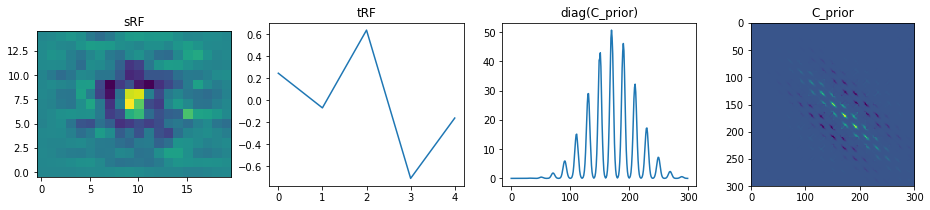

============200============
sigma: 9.797299897739295
rho: -2.124079050625422
nux: [array(8.16197586), array(9.94786408)]
nuf: [array(0.82645551), array(2.82658206)]
taux: [array(1.30886715), array(1.61717691), array(-0.02106048)]
tauf: [array(0.00276798), array(0.02129725), array(1.16255426)]
cost: 103.36276654160359


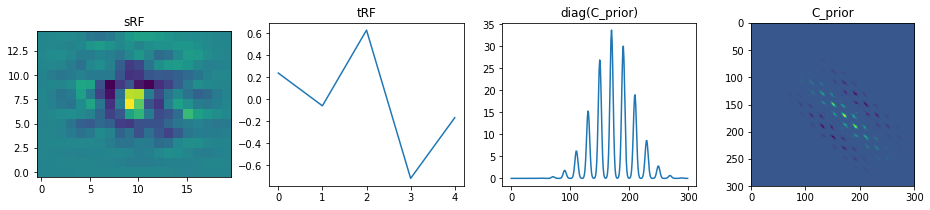

============300============
sigma: 9.694306204778547
rho: -2.053630393039584
nux: [array(8.18749802), array(9.82883323)]
nuf: [array(0.75850307), array(2.75724407)]
taux: [array(1.22294568), array(1.53997095), array(-0.02403631)]
tauf: [array(-2.17536535e-05), array(0.00135268), array(1.21895287)]
cost: 101.19991452337904


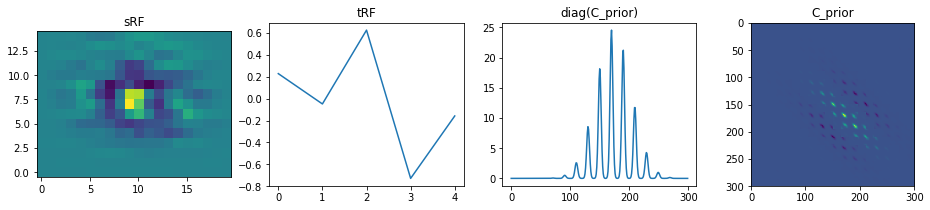

============400============
sigma: 9.590632630838025
rho: -1.9924053685329794
nux: [array(8.19049402), array(9.75220055)]
nuf: [array(0.6999143), array(2.69945825)]
taux: [array(1.14425674), array(1.47117309), array(-0.02974939)]
tauf: [array(-2.39331468e-05), array(8.63173368e-06), array(1.26360197)]
cost: 100.01267055900998


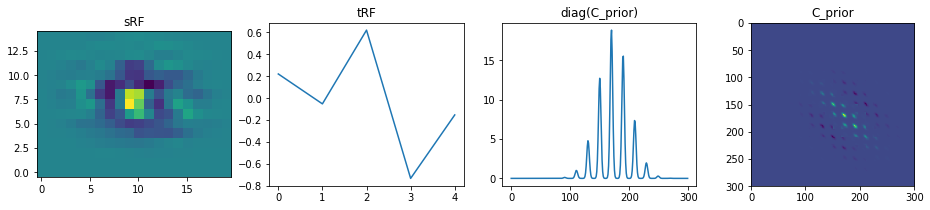

============500============
sigma: 9.486466991303438
rho: -1.9386076728994763
nux: [array(8.19176467), array(9.72099634)]
nuf: [array(0.64885563), array(2.65024133)]
taux: [array(1.07318827), array(1.40845332), array(-0.03605749)]
tauf: [array(-1.6760396e-05), array(6.67833387e-06), array(1.29998179)]
cost: 99.05793836050124


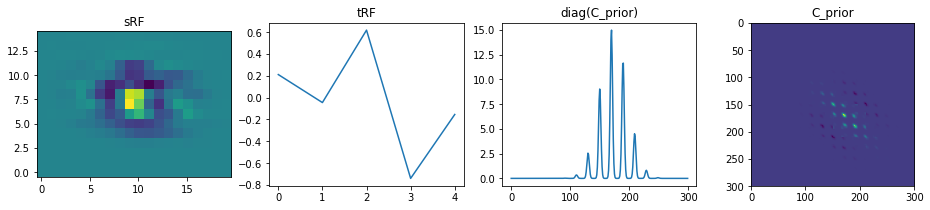

============Optimized============
sigma: 9.485423227178718
rho: -1.9381029828640248
nux: [array(8.19177791), array(9.72113592)]
nuf: [array(0.64837643), array(2.64979026)]
taux: [array(1.07251994), array(1.40785292), array(-0.03612432)]
tauf: [array(2.8129786e-05), array(8.61340727e-06), array(1.300312)]
cost: 99.04832329574197


In [6]:
cost_list = []
import numpy as np
def callback(params, t, g):
    if t % 100 == 0:
        sigma = params[0]
        rho = params[1]
        nux =params[2]
        nuf = params[3]
        taux = params[4]
        tauf = params[5]

        print('============{}============'.format(t))
        print('sigma: {0}'.format(sigma))
        print('rho: {0}'.format(rho))
        print('nux: {}'.format(nux))
        print('nuf: {}'.format(nuf))
        print('taux: {}'.format(taux))
        print('tauf: {}'.format(tauf))
            
        (C_prior, 
         C_prior_inv) = opt.update_C_prior(params)
        
        (C_post, 
         C_post_inv, 
         m_post) = opt.update_posterior(params,
                                        C_prior,
                                        C_prior_inv)  
        
        cost = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ m_post.reshape(np.product([*m_post.shape]), 1))
        cost_list.append(cost)
        print('cost: {0}'.format(cost))
        
        k,S,kt = randomized_svd(m_post, 3)
        
        fig, ax = plt.subplots(1,4, figsize=(16,3))
        
        ax[0].imshow(k[:, 0].reshape(15,20), origin='lower')
        ax[1].plot(kt[0])
        ax[2].plot(np.diag(C_prior))
        ax[3].imshow(C_prior)
        
        ax[0].set_title('sRF')
        ax[1].set_title('tRF')
        ax[2].set_title('diag(C_prior)')
        ax[3].set_title('C_prior')
        
        plt.show()
        
opt = rfest.ALD(X, Y, rf_dims=(15,20,5))

opt.fit(initial_params=[10., -2.3, [8., 10.], [1., 3.], 
                       [1.5,1.8, 0.], [0.15, 0.15, 1.]],
        num_iters=501,callback=callback)

print('============Optimized============')
opt_params = opt.optimized_params
sigma = opt_params[0]
rho = opt_params[1]
nux =opt_params[2]
nuf = opt_params[3]
taux = opt_params[4]
tauf = opt_params[5]

print('sigma: {0}'.format(sigma))
print('rho: {0}'.format(rho))
print('nux: {}'.format(nux))
print('nuf: {}'.format(nuf))
print('taux: {}'.format(taux))
print('tauf: {}'.format(tauf))
    
(C_prior, 
 C_prior_inv) = opt.update_C_prior(opt_params)

(C_post, 
 C_post_inv, 
 m_post) = opt.update_posterior(opt_params,
                                C_prior,
                                C_prior_inv)  

cost = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ m_post.reshape(np.product([*m_post.shape]), 1))
cost_list.append(cost)
print('cost: {0}'.format(cost))

Text(0.5,1,'t_asd')

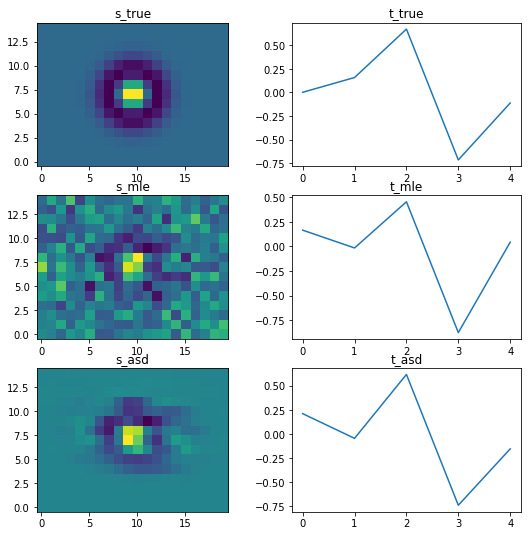

In [7]:
U_true, S, Vt_true = randomized_svd(w_true.reshape(300,5), 3)

fig, ax = plt.subplots(3,2, figsize=(9, 9))
ax[0, 0].imshow(U_true[:, 0].reshape(15, 20), origin='lower')
ax[0, 1].plot(Vt_true[0])

ax[1, 0].imshow(opt.sRF_mle, origin='lower')
ax[1, 1].plot(opt.tRF_mle)

ax[2, 0].imshow(opt.sRF_opt, origin='lower')
ax[2, 1].plot(opt.tRF_opt)


ax[0,0].set_title('s_true')
ax[0,1].set_title('t_true')

ax[1,0].set_title('s_mle')
ax[1,1].set_title('t_mle')

ax[2,0].set_title('s_asd')
ax[2,1].set_title('t_asd')